In [1]:
import calendar
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from shapely.geometry import Point

palette = sns.color_palette("colorblind", 20)

spark = (
    SparkSession.builder
        .master("local")
        .appName("TFL Notebook")
        .config('spark.executor.memory', '8G')
        .config('spark.driver.memory', '16G')
        .config('spark.driver.maxResultSize', '10G')
        .config("spark.sql.crossJoin.enabled", "true")
        .getOrCreate()
)

trips = spark.read.parquet("../data/parquet_trip")
trips.createOrReplaceTempView("trips")

df = spark.sql("""
    select 
      count(distinct(bike_id)) as bike_count, 
      count(1) as trip_count, 
      start_year, 
      start_month,
      start_year || '-' || start_month as month
    from trips
    group by start_year, start_month
    order by start_year asc, start_month asc
""")

def month_label(year, month):
    return "{0} {1}".format(calendar.month_name[int(month)], year)

month_label_udf = udf(month_label, StringType())
df = df.withColumn("month_label", month_label_udf("start_year", "start_month"))

df.createOrReplaceTempView("monthly_counts")

monthly_counts = df.toPandas()

monthly_counts.head(10)

,bike_count,trip_count,start_year,start_month,month,month_label
0,11319,546113,2015,1,2015-1,January 2015
1,11284,542526,2015,2,2015-2,February 2015
2,11348,694364,2015,3,2015-3,March 2015
3,11391,829921,2015,4,2015-4,April 2015
4,11327,892692,2015,5,2015-5,May 2015
5,11217,1030640,2015,6,2015-6,June 2015
6,11294,1122670,2015,7,2015-7,July 2015
7,11198,1030760,2015,8,2015-8,August 2015
8,11153,894635,2015,9,2015-9,September 2015
9,11146,876245,2015,10,2015-10,October 2015


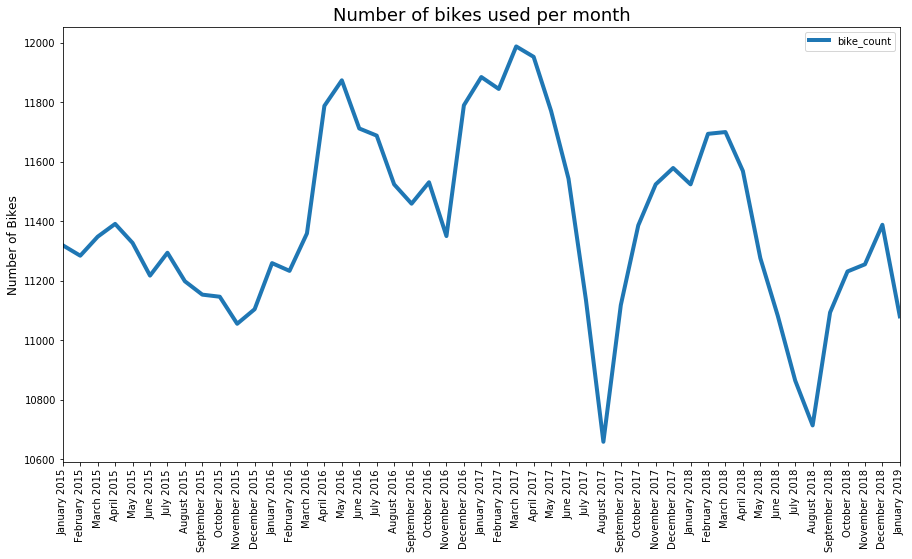

In [2]:
fig, ax = plt.subplots(figsize=(15, 8))

monthly_counts.plot(ax=ax, kind='line', x='month_label', xticks=range(0, len(monthly_counts)), y='bike_count', linewidth=4.0)

plt.title("Number of bikes used per month", fontsize=18)
plt.xlabel('')
#plt.ylim(bottom=0, top=13000)
plt.xticks(rotation=90)
plt.ylabel('Number of Bikes', fontsize=12)
plt.legend(loc='best')
plt.show()


In [3]:
df = spark.sql("""
    select 
      count(distinct(t.bike_id)) as bike_count,
      t.start_year, 
      t.start_month,
      t.start_day
    from trips t
    group by t.start_year, t.start_month, t.start_day
""")
df.createOrReplaceTempView("daily_counts")

df = spark.sql("""
    select 
      dc.bike_count as bikes_used,
      mc.bike_count as bikes_available,
      mc.bike_count - dc.bike_count as unused_bikes,
      dc.start_year, 
      dc.start_month,
      dc.start_day
    from daily_counts dc
    join monthly_counts mc on (dc.start_year = mc.start_year and dc.start_month = mc.start_month)
""")
df.createOrReplaceTempView("daily_usage")

df = spark.sql("""
    select 
      min(bikes_used) as bikes_used_min,
      max(bikes_used) as bikes_used_max,
      avg(bikes_used) as bikes_used_avg,
      max(bikes_available) as bikes_available,
      min(unused_bikes) as unused_bikes_min,
      max(unused_bikes) as unused_bikes_max,
      avg(unused_bikes) as unused_bikes_avg,
      start_year, 
      start_month
    from daily_usage
    group by start_year, start_month
    order by start_year asc, start_month asc
""")

df = df.withColumn("month_label", month_label_udf("start_year", "start_month"))

utilisation = df.toPandas()

utilisation.head(10)

,bikes_used_min,bikes_used_max,bikes_used_avg,bikes_available,unused_bikes_min,unused_bikes_max,unused_bikes_avg,start_year,start_month,month_label
0,4154,7411,6432.285714,11319,3908,7165,4886.714286,2015,1,January 2015
1,4440,7585,6465.000000,11284,3699,6844,4819.000000,2015,2,February 2015
2,4039,7757,6801.064516,11348,3591,7309,4546.935484,2015,3,March 2015
3,4848,8144,7317.833333,11391,3247,6543,4073.166667,2015,4,April 2015
4,5439,8507,7544.064516,11327,2820,5888,3782.935484,2015,5,May 2015
5,6749,8578,7981.866667,11217,2639,4468,3235.133333,2015,6,June 2015
6,5002,9522,7824.548387,11294,1772,6292,3469.451613,2015,7,July 2015
7,4159,9485,7671.774194,11198,1713,7039,3526.225806,2015,8,August 2015
8,6266,8343,7588.900000,11153,2810,4887,3564.100000,2015,9,September 2015
9,5860,8390,7555.290323,11146,2756,5286,3590.709677,2015,10,October 2015


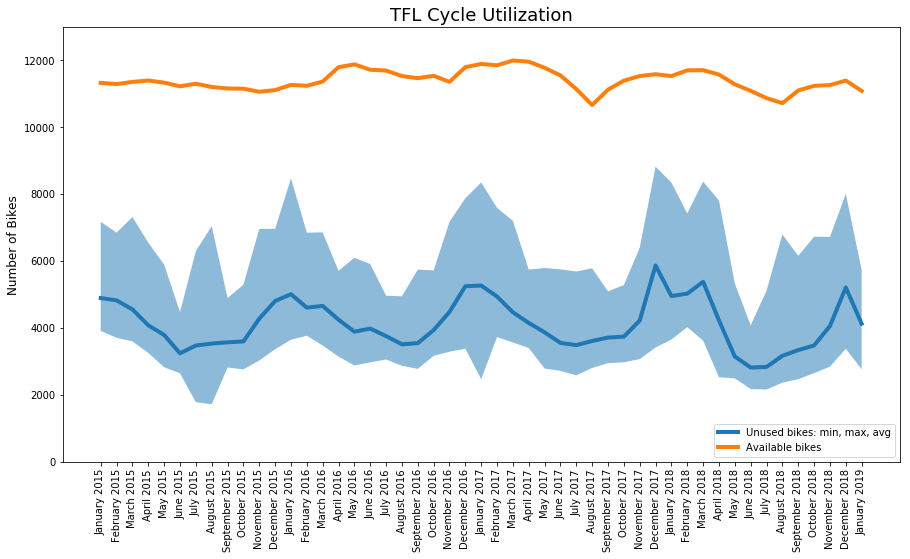

In [4]:
df = spark.sql("""
    select 
      min(bikes_used) as bikes_used_min,
      max(bikes_used) as bikes_used_max,
      avg(bikes_used) as bikes_used_avg,
      max(bikes_available) as bikes_available,
      min(unused_bikes) as unused_bikes_min,
      max(unused_bikes) as unused_bikes_max,
      avg(unused_bikes) as unused_bikes_avg,
      start_year, 
      start_month
    from daily_usage
    group by start_year, start_month
    order by start_year asc, start_month asc
""")

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(utilisation['month_label'], utilisation['unused_bikes_avg'], linewidth=4.0, label="Unused bikes: min, max, avg")
ax.fill_between(utilisation['month_label'], utilisation['unused_bikes_min'], utilisation['unused_bikes_max'], alpha=0.5)

ax.plot(utilisation['month_label'], utilisation['bikes_available'], linewidth=4.0, label="Available bikes")

plt.title("TFL Cycle Utilization", fontsize=18)
plt.xlabel('')
plt.ylim(bottom=0, top=13000)
plt.xticks(rotation=90)
plt.ylabel('Number of Bikes', fontsize=12)
plt.legend(loc='lower right')
plt.show()
